
### Imports and Global Constants


In [2]:

import os
import tensorflow as tf
from tensorflow.data import AUTOTUNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
import shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
import time
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# Set AutoTune (optional if already imported from tensorflow.data)
AUTOTUNE = tf.data.AUTOTUNE

# Global configuration parameters
INP_SIZE = (512, 512)         # Input size of the Image Resizer Module (IRM)
TARGET_SIZE = (224, 224)      # Output size of IRM and Input size of the Vision Transformer
INTERPOLATION = "bilinear"
N_CLASSES = 6
NUM_FOLDS = 5
BATCH_SIZE = 16
SEED = 42
DATA_DIR = "cleaned_african_plums_dataset"

np.random.seed(SEED)
tf.random.set_seed(SEED)

### File Paths and Directory Setup

In [3]:
# File Paths and Directory Setup

model_path = os.path.join("files", "EfficientNetb3-final.keras")
csv_path = os.path.join("files", "log.csv")

# Create directory for storing files
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

create_dir("files")

# Data Augmentation and Decoding Functions

def build_augmenter(is_labelled):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.resize(img, [256, 256])  # Slightly larger before cropping
        img = tf.image.random_crop(img, size=[TARGET_SIZE[0], TARGET_SIZE[1], 3])
        return img
    # Wrapper for images with labels
    def augment_with_labels(img, label):
        return augment(img), label
    # Wrapper for unlabeled images
    def augment_without_labels(img):
        return augment(img)

    return augment_with_labels if is_labelled else augment_without_labels
# Function to build a decoder to read and preprocess images from file paths

def build_decoder(is_labelled, size):
    def decode(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, (size[0], size[1]))
        return tf.cast(tf.divide(img, 255.), tf.float32)

    def decode_with_labels(path, label):
        return decode(path), label

    def decode_without_labels(path):
        return decode(path)

    return decode_with_labels if is_labelled else decode_without_labels


# Function to create a TensorFlow Dataset pipeline
def create_dataset(image_paths, labels=None, batch_size=32, is_labelled=False, augment=False, repeat=False, shuffle=False, size=INP_SIZE):
    decode_fn = build_decoder(is_labelled, size)
    augmenter_fn = build_augmenter(is_labelled)

    # Build dataset from image paths (and labels if available)
    if is_labelled and labels is not None:
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(image_paths)

    # Decode image files
    dataset = dataset.map(decode_fn, num_parallel_calls=AUTOTUNE)

    # Optionally apply augmentations
    if augment:
        dataset = dataset.map(augmenter_fn, num_parallel_calls=AUTOTUNE)

    # Repeat dataset for multiple epochs (if specified)
    if repeat:
        dataset = dataset.repeat()

    # Shuffle the dataset (if specified)
    if shuffle:
        dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)

    # Batch and prefetch for performance
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset


###  Data Loading and Preprocessing

In [4]:


# Initialize empty lists to store image file paths and their corresponding labels
image_paths = []
labels = []

# Traverse the dataset directory where images are organized by label folders
for label in os.listdir(DATA_DIR):
    label_dir = os.path.join(DATA_DIR, label)

    # Only process directories (ignore hidden files or metadata)
    if os.path.isdir(label_dir):
        # List all image files in the current label folder
        label_images = [os.path.join(label_dir, img) for img in os.listdir(label_dir)]

        # Add the image paths to the master list
        image_paths.extend(label_images)

        # Add corresponding label name for each image
        labels.extend([label] * len(label_images))

# Encode string labels into numerical format using sklearn's LabelEncoder
# e.g., {"bruised": 0, "cracked": 1, ...}
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)



In [5]:
# Display the mapping: encoded label -> class name
print("Encoded Label Mapping:")
for index, class_name in enumerate(label_encoder.classes_):
    print(f"{index}: {class_name}")

Encoded Label Mapping:
0: bruised
1: cracked
2: rotten
3: spotted
4: unaffected
5: unripe


In [6]:

# Split the data into train, validation, and test sets
image_paths_trainval, image_paths_test, labels_trainval, labels_test = train_test_split(
    image_paths, encoded_labels, test_size=0.2, random_state=SEED
)
image_paths_train, image_paths_val, labels_train, labels_val = train_test_split(
    image_paths_trainval, labels_trainval, test_size=0.1, random_state=SEED
)

# Create the tf.data.Datasets for training, validation, and testing
train_ds = create_dataset(
    image_paths_train, labels=labels_train, batch_size=BATCH_SIZE, is_labelled=True,
    augment=True, repeat=True, shuffle=True, size=TARGET_SIZE
)

val_ds = create_dataset(
    image_paths_val, labels=labels_val, batch_size=BATCH_SIZE, is_labelled=True,
    augment=False, repeat=False, shuffle=False, size=TARGET_SIZE
)
test_ds = create_dataset(
    image_paths_test, labels=labels_test, batch_size=BATCH_SIZE, is_labelled=True,
    augment=False, repeat=False, shuffle=False, size=TARGET_SIZE
)


In [7]:
# If you used sklearn's LabelEncoder
label_index_to_name = {i: name for i, name in enumerate(label_encoder.classes_)}


In [8]:
#funtion to save images to train, val and test folders
def save_images_to_folders(image_paths, labels, base_dir, label_index_to_name):
    os.makedirs(base_dir, exist_ok=True)
    for path, label in zip(image_paths, labels):
        class_name = label_index_to_name[label]
        class_dir = os.path.join(base_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        filename = os.path.basename(path)
        dest_path = os.path.join(class_dir, filename)
        shutil.copy(path, dest_path)


# Save images into train/val/test folders
save_images_to_folders(image_paths_train, labels_train, "train", label_index_to_name)
save_images_to_folders(image_paths_val, labels_val, "val", label_index_to_name)
save_images_to_folders(image_paths_test, labels_test, "test", label_index_to_name)


In [9]:
labels_train = tf.keras.utils.to_categorical(labels_train, num_classes=N_CLASSES)
labels_val = tf.keras.utils.to_categorical(labels_val, num_classes=N_CLASSES)
labels_test = tf.keras.utils.to_categorical(labels_test, num_classes=N_CLASSES)


In [10]:

def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
        mlb = MultiLabelBinarizer()
        class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))


In [11]:
# Fixed dataset and class weights code

class_weights = generate_class_weights(labels_train, multi_class=True, one_hot_encoded=True)

# Make sure loss function matches your label format


In [12]:
def one_hot_encode(image, label):
    return image, tf.one_hot(label, depth=N_CLASSES)

train_ds = train_ds.map(one_hot_encode, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_encode, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(one_hot_encode, num_parallel_calls=AUTOTUNE)

### Implementing Cutmix augmentation

In [13]:
# Mixes two images and their labels by cutting and pasting patches between them.
# Helps improve model generalization and robustness.

def cutmix_batch(images, labels, num_classes, alpha=1.0, min_lam=0.3, max_lam=0.7):
    batch_size = tf.shape(images)[0]
    img_h = tf.shape(images)[1]
    img_w = tf.shape(images)[2]

    # Randomly sample lambda values from a uniform distribution [min_lam, max_lam]
    lam = tf.random.uniform((batch_size,), minval=min_lam, maxval=max_lam)

    # Calculate cut-out size (CutMix region)
    cut_ratios = tf.sqrt(1. - lam)
    cut_w = tf.cast(cut_ratios * tf.cast(img_w, tf.float32), tf.int32)
    cut_h = tf.cast(cut_ratios * tf.cast(img_h, tf.float32), tf.int32)

    # Generate random center points for the CutMix patch
    cx = tf.random.uniform((batch_size,), 0, img_w, dtype=tf.int32)
    cy = tf.random.uniform((batch_size,), 0, img_h, dtype=tf.int32)

    # Calculate bounding box coordinates for the patch
    x1 = tf.clip_by_value(cx - cut_w // 2, 0, img_w)
    y1 = tf.clip_by_value(cy - cut_h // 2, 0, img_h)
    x2 = tf.clip_by_value(cx + cut_w // 2, 0, img_w)
    y2 = tf.clip_by_value(cy + cut_h // 2, 0, img_h)

    # Randomly shuffle the batch for pairing images/labels
    indices = tf.random.shuffle(tf.range(batch_size))
    shuffled_images = tf.gather(images, indices)
    shuffled_labels = tf.gather(labels, indices)

    # === Helper Function: Apply CutMix for one sample ===
    def cutmix_one(i):
        img1 = images[i]             # Original image
        img2 = shuffled_images[i]    # Image to cut from
        y1_i, y2_i = y1[i], y2[i]
        x1_i, x2_i = x1[i], x2[i]

        # Extract patch from img2
        patch = img2[y1_i:y2_i, x1_i:x2_i, :]

        # Pad the patch to match img1 shape
        paddings = [[y1_i, img_h - y2_i], [x1_i, img_w - x2_i], [0, 0]]
        patch_padded = tf.pad(patch, paddings, constant_values=0)

        # Create mask to combine images
        mask = tf.cast(patch_padded > 0, tf.float32)

        # Mix the two images
        new_img = img1 * (1. - mask) + patch_padded

        # Adjust lambda proportion based on patch area
        area = tf.cast((x2_i - x1_i) * (y2_i - y1_i), tf.float32)
        lam_adj = 1. - (area / tf.cast(img_h * img_w, tf.float32))

        # Blend the labels using adjusted lambda
        label1 = labels[i]
        label2 = shuffled_labels[i]
        mixed_label = lam_adj * label1 + (1. - lam_adj) * label2

        return new_img, mixed_label

    # === Apply CutMix to entire batch using tf.map_fn ===
    output_signature = (
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)
    )

    return tf.map_fn(cutmix_one, tf.range(batch_size), fn_output_signature=output_signature)


In [14]:
# Fixed visualization code with proper imports
def visualize_features(model, test_ds):
    
    # Get the total number of layers
    n_layers = len(model.layers)
    
    # Create a model that outputs intermediate layer outputs
    feature_extractor = Model(inputs=model.inputs, outputs=model.layers[n_layers - 2].output)
    
    # Extract features 
    all_features = []
    all_labels = []
    
    # Process batches to avoid memory issues
    for images, labels in test_ds:
        batch_features = feature_extractor.predict(images)
        all_features.append(batch_features)
        all_labels.append(labels)
    
    # Concatenate all batches
    features = np.concatenate(all_features, axis=0)
    test_labels = np.concatenate(all_labels, axis=0)
    
    # Convert one-hot labels to integers if needed
    if len(test_labels.shape) > 1 and test_labels.shape[1] > 1:
        test_labels = np.argmax(test_labels, axis=1)
    
    # Apply t-SNE on the extracted features
    features_embedded = TSNE(n_components=2).fit_transform(features)
    # Get unique class labels
    unique_labels = np.unique(test_labels)
    
    # Plot the features in a 2D space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_embedded[:, 0], features_embedded[:, 1], 
                          c=test_labels, cmap='Spectral')
    
    # Add a colorbar with class names
    colorbar = plt.colorbar(ticks=unique_labels)
    colorbar.set_ticklabels(label_encoder.classes_)
    plt.title('t-SNE Visualization of Learned Features')
    plt.show()

In [15]:

num_classes = 6  # or whatever your dataset has

def apply_cutmix(images, labels):
    return cutmix_batch(images, labels, num_classes=num_classes)

train_ds = train_ds.map(apply_cutmix, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)



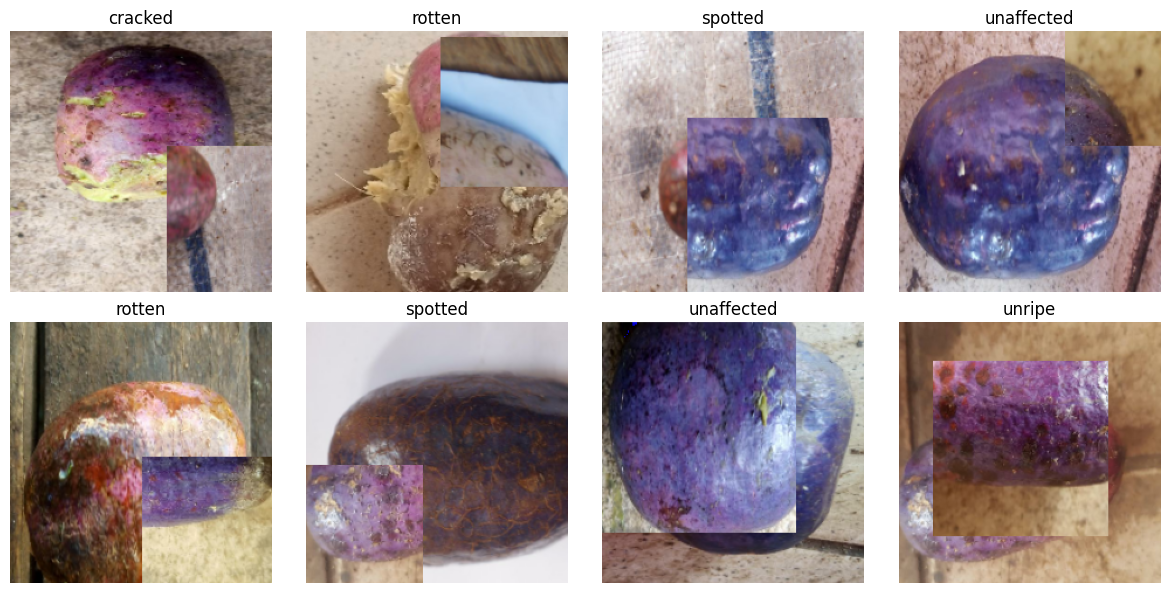

2025-04-16 07:08:39.273532: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
#showing some images after cutmix
def show_batch(dataset, class_names):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(12, 6))
        for i in range(8):
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy())
            label = tf.argmax(labels[i]).numpy() if len(labels.shape) > 1 else labels[i].numpy()
            plt.title(class_names[label])
            plt.axis("off")
        plt.tight_layout()
        plt.show()

# Call this after train_ds is created
show_batch(train_ds, class_names=label_encoder.classes_)


### Model Building

In [17]:
# === Function: Get Pretrained CNN Model with Custom Classifier Head ===
def get_model(model_name, input_shape, num_classes=3):
    """
    Loads a pretrained CNN base model (ImageNet weights) and attaches a classification head.

    Parameters:
    - model_name (str): Name of the base model to use (e.g., 'efficientb3', 'resnet50')
    - input_shape (tuple): Shape of input images (e.g., (224, 224, 3))
    - num_classes (int): Number of output classes (default = 3)

    Returns:
    - A compiled tf.keras.Model ready for training or inference
    """

    if model_name == 'vgg16':
        base_model = tf.keras.applications.VGG16(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'resnet50':
        base_model = tf.keras.applications.ResNet50(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'xception':
        base_model = tf.keras.applications.Xception(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'vgg19':
        base_model = tf.keras.applications.VGG19(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'resnet50v2':
        base_model = tf.keras.applications.ResNet50V2(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'resnet101':
        base_model = tf.keras.applications.ResNet101(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'resnet101v2':
        base_model = tf.keras.applications.ResNet101V2(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'resnet152':
        base_model = tf.keras.applications.ResNet152(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'resnet152v2':
        base_model = tf.keras.applications.ResNet152V2(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'inceptionv3':
        base_model = tf.keras.applications.InceptionV3(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'inceptionresnetv2':
        base_model = tf.keras.applications.InceptionResNetV2(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'mobilenet':
        base_model = tf.keras.applications.MobileNet(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'mobilenetv2':
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'densenet121':
        base_model = tf.keras.applications.DenseNet121(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'densenet169':
        base_model = tf.keras.applications.DenseNet169(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'densenet201':
        base_model = tf.keras.applications.DenseNet201(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'nasnetmobile':
        base_model = tf.keras.applications.NASNetMobile(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'nasnetlarge':
        base_model = tf.keras.applications.NasNetLarge(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'efficientnetb0':
        base_model = tf.keras.applications.EfficientNetB0(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'efficientb1':
        base_model = tf.keras.applications.EfficientNetB1(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'efficientb2':
        base_model = tf.keras.applications.EfficientNetB2(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'efficientb3':
        base_model = tf.keras.applications.EfficientNetB3(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'efficientb4':
        base_model = tf.keras.applications.EfficientNetB4(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'efficientb5':
        base_model = tf.keras.applications.EfficientNetB5(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'efficientb6':
        base_model = tf.keras.applications.EfficientNetB6(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'efficientb7':
        base_model = tf.keras.applications.EfficientNetB7(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'efficientnetv2b0':
        base_model = tf.keras.applications.EfficientNetV2B0(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'efficientnet2b1':
        base_model = tf.keras.applications.EfficientNetV2B1(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'efficientnet2b2':
        base_model = tf.keras.applications.EfficientNetV2B2(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'efficientnet2b3':
        base_model = tf.keras.applications.EfficientNetV2B3(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'efficientnetv2s':
        base_model = tf.keras.applications.EfficientNetV2S(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'efficientnetv2m':
        base_model = tf.keras.applications.EfficientNetV2M(
            input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == 'efficientnetv2l':
        base_model = tf.keras.applications.EfficientNetV2L(
            input_shape=input_shape, include_top=False, weights="imagenet")
    else:
        raise ValueError(
            "Invalid model name. Choose from 'vgg16', 'resnet50', or 'xception'.")

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)

    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    if num_classes == 2:
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    else:
        x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)

    model.summary()

    return model

In [18]:
# Build a model using EfficientNetB3 as the feature extractor
# Input images are resized to 224x224 with 3 channels (RGB)
# The task is 6-class classification (e.g., 6 types of plum conditions)

model = get_model('efficientb3', input_shape=(224, 224, 3), num_classes=6)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 1536)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,573,557 (44.15 MB)

 Trainable params: 11,486,254 (43.82 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [19]:
# === Debug: Inspect One Batch from train_ds ===

# Take one batch from the training dataset
for x, y in train_ds.take(1):
    # Print the shape of the input images (e.g., (32, 224, 224, 3) for a batch of 32 RGB images)
    print("Input shape:", x.shape)

    # Print the shape of the labels (e.g., (32, 6) for one-hot encoded 6-class labels)
    print("Label shape:", y.shape)

    # Show the first label in the batch (should be a one-hot encoded vector)
    print("Label sample:", y[0])


Input shape: (16, 224, 224, 3)
Label shape: (16, 6)
Label sample: tf.Tensor([0. 0. 0. 0. 1. 0.], shape=(6,), dtype=float32)


2025-04-16 07:08:41.408223: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Training
- A lot of experiments were done on Kaggle but the final model was trained on a MacBook Pro m2 with 8GB of RAM.

In [20]:

# Define the learning rate schedule
steps_per_epoch = len(image_paths_train) // BATCH_SIZE
boundaries = [steps_per_epoch * n for n in [5, 10]]
values = [0.001, 0.0001, 0.00001]

# Set up the learning rate scheduler and optimizer
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
optimizer = tf.keras.optimizers.Adam(lr_sched)

# # Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=["accuracy", "top_k_categorical_accuracy"]
)

# Define the callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6),
    tf.keras.callbacks.CSVLogger(csv_path),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=False)
]

# Define the number of validation steps
validation_steps = len(image_paths_val) // BATCH_SIZE


# Start the timer
start_time = time.time()

history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=callbacks,
    )


print("This the End!!!")
# Stop the timer after training completes
end_time = time.time()

# Calculate the total training time
training_time = end_time - start_time

# Print the total training time in a human-readable format (hours, minutes, seconds)
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Training Time: {int(hours)} hours, {int(minutes)} minutes, and {int(seconds)} seconds.")

print("This is the End!!!")

Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2886 - loss: 4.0951 - top_k_categorical_accuracy: 0.9289
Epoch 1: val_loss improved from inf to 1.98211, saving model to files/EfficientNetb3-final.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.2890 - loss: 4.0866 - top_k_categorical_accuracy: 0.9290 - val_accuracy: 0.4625 - val_loss: 1.9821 - val_top_k_categorical_accuracy: 0.9417 - learning_rate: 1.0000e-04
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3930 - loss: 1.6988 - top_k_categorical_accuracy: 0.9378
Epoch 2: val_loss improved from 1.98211 to 1.90370, saving model to files/EfficientNetb3-final.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/step - accuracy: 0.3930 - loss: 1.6984 - top_k_categorical_accuracy: 0.9378 - val_accuracy: 0.4333 - val_loss: 1.9037 - val_top_k_categorical_accuracy: 0.9458 - learning_rate: 1.0000e-04
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4766 - loss: 1.4776 - top_k_categorical_accur

### Evaluation and Metrics Reports

In [21]:
model.evaluate(test_ds)

38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 295ms/step - accuracy: 0.7200 - loss: 0.8014 - top_k_categorical_accuracy: 0.9902


[0.8161095380783081, 0.6978297233581543, 0.9933221936225891]

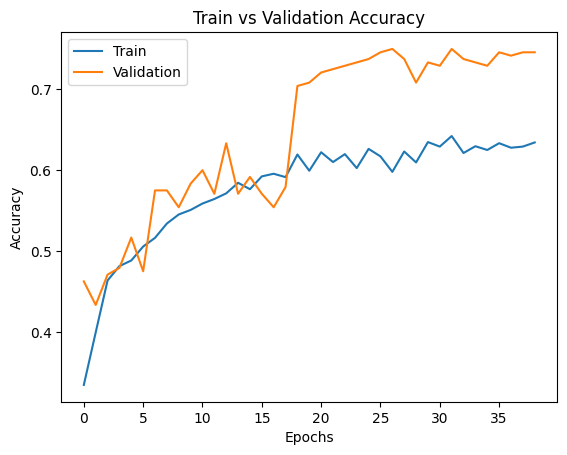

In [22]:


# Train vs validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

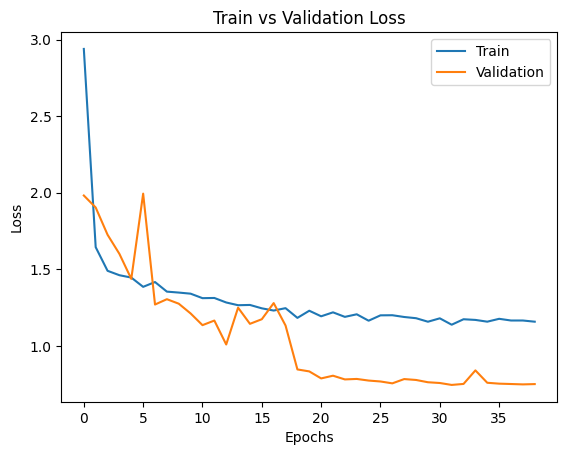

In [23]:
# Train vs validation accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

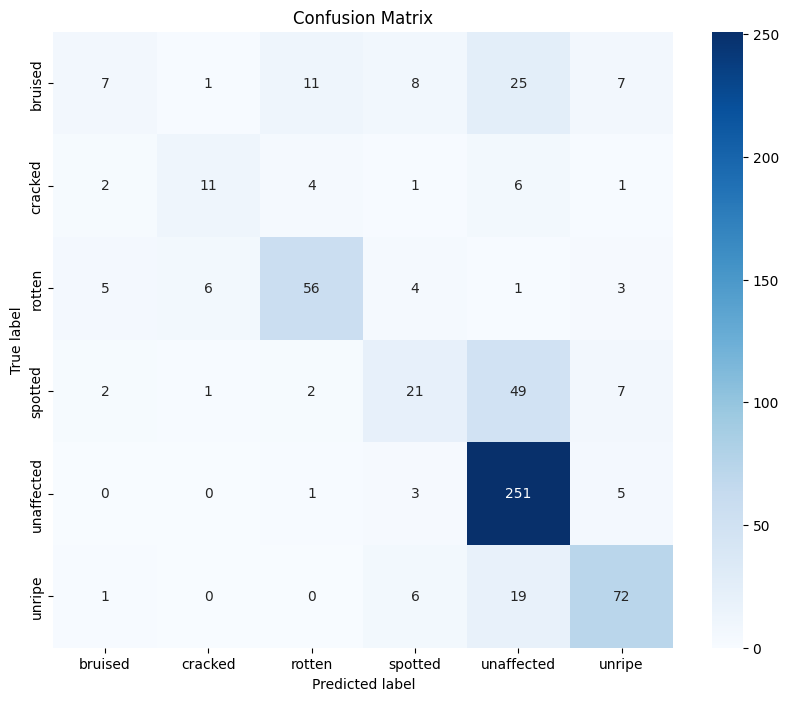

In [24]:


# Make predictions
y_pred = []
y_true = []
for imgs, labels in test_ds:
    predictions = model.predict(imgs)
    y_pred.extend(np.argmax(predictions, axis=1))
    # Convert one-hot encoded labels to class indices
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    #y_true.extend(labels.numpy())

# Create a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()



/Applications/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_385']
Received: inputs=Tensor(shape=(16, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

/Applications/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_385']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


2025-04-16 10:42:11.145413: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


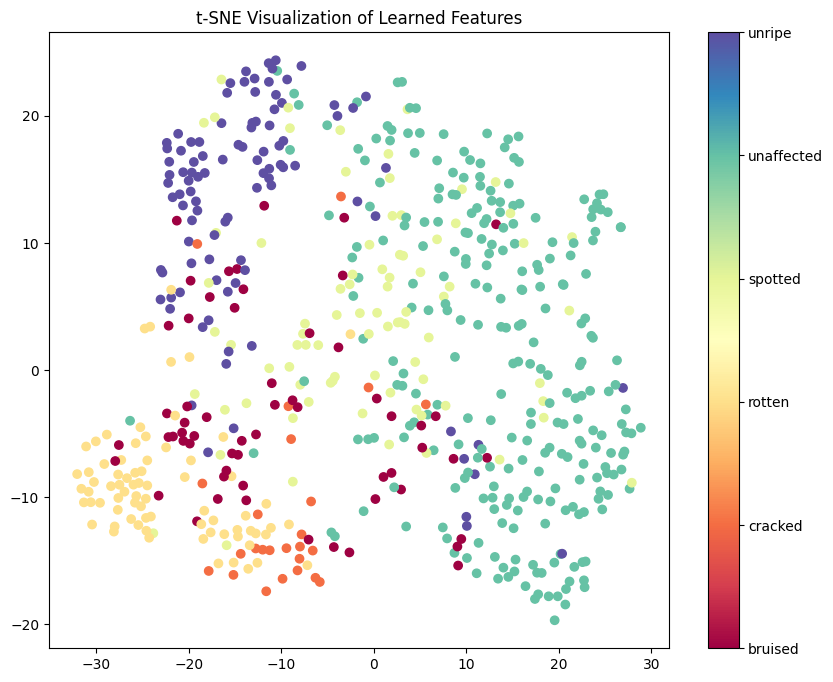

In [25]:
visualize_features(model, test_ds)

In [26]:
# Print the classification report
class_report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

     bruised       0.41      0.12      0.18        59
     cracked       0.58      0.44      0.50        25
      rotten       0.76      0.75      0.75        75
     spotted       0.49      0.26      0.34        82
  unaffected       0.72      0.97      0.82       260
      unripe       0.76      0.73      0.75        98

    accuracy                           0.70       599
   macro avg       0.62      0.54      0.56       599
weighted avg       0.66      0.70      0.66       599



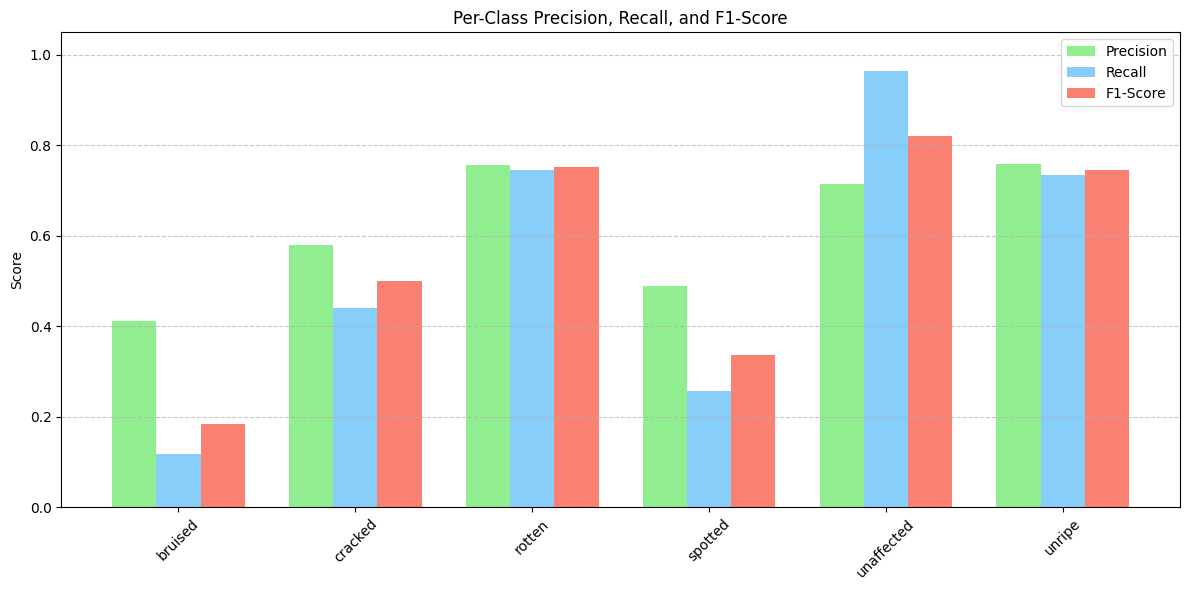

In [58]:

import pandas as pd

# Generate classification report as a dictionary
report_dict = classification_report(
    y_true, y_pred, target_names=label_encoder.classes_, output_dict=True
)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Filter only class-level rows (exclude 'accuracy', 'macro avg', etc.)
class_metrics_df = report_df.iloc[:N_CLASSES][['precision', 'recall', 'f1-score']]

# Plot grouped bar chart
x = np.arange(len(class_metrics_df))  # label locations
width = 0.25  # width of the bars

plt.figure(figsize=(12, 6))
plt.bar(x - width, class_metrics_df['precision'], width, label='Precision', color='lightgreen')
plt.bar(x, class_metrics_df['recall'], width, label='Recall', color='lightskyblue')
plt.bar(x + width, class_metrics_df['f1-score'], width, label='F1-Score', color='salmon')

# Labels & formatting
plt.ylabel('Score')
plt.title('Per-Class Precision, Recall, and F1-Score')
plt.xticks(x, label_encoder.classes_, rotation=45)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
